In [2]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord

from plato.field import find_targets
from plato.visualisation import FigureProcessor, get_palette, set_plot_defaults

In [3]:
# field = "LOPN1"
# data_all_sky = pd.read_csv("../data/processed/all_sky_targets.csv")

# # add n_cameras column for field
# data = find_targets(
#     data_all_sky,
#     field = field,
# )
# print(f"Number of targets found in field {field}: {(data["n_cameras"] > 0).sum()}")
# data[data["n_cameras"] > 0].to_csv(f"../data/processed/{field}_targets.csv", index=False)

In [4]:
all_sky = pd.read_csv("../data/processed/all_sky_targets.csv")
LOPS2 = pd.read_csv(f"../data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(f"../data/processed/LOPN1_targets.csv")

all_sky["Field"] = "All-Sky"
all_sky["n_cameras"] = 0
LOPS2["Field"] = "LOPS2"
LOPN1["Field"] = "LOPN1"

all_sky = all_sky[~all_sky["gaiaID_DR3"].isin(LOPS2["gaiaID_DR3"])]
all_sky = all_sky[~all_sky["gaiaID_DR3"].isin(LOPN1["gaiaID_DR3"])]
data = pd.concat([all_sky, LOPS2, LOPN1])

/tmp/ipykernel_5488/778520586.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  all_sky = pd.read_csv("../data/processed/all_sky_targets.csv")


## PLOT TARGETS

In [5]:
set_plot_defaults()

figure_directory = f"../figures/03_plato_fields"
save = False

In [6]:
targets = data[["GLON", "GLAT", "n_cameras", "Population"]].copy()
target_coords = SkyCoord(
    l=targets["GLON"],
    b=targets["GLAT"],
    unit="deg",
    frame="galactic",
)
targets["GLON"] = -target_coords.l.wrap_at(180 * u.deg).rad  # type: ignore
targets["GLAT"] = target_coords.b.rad  # type: ignore

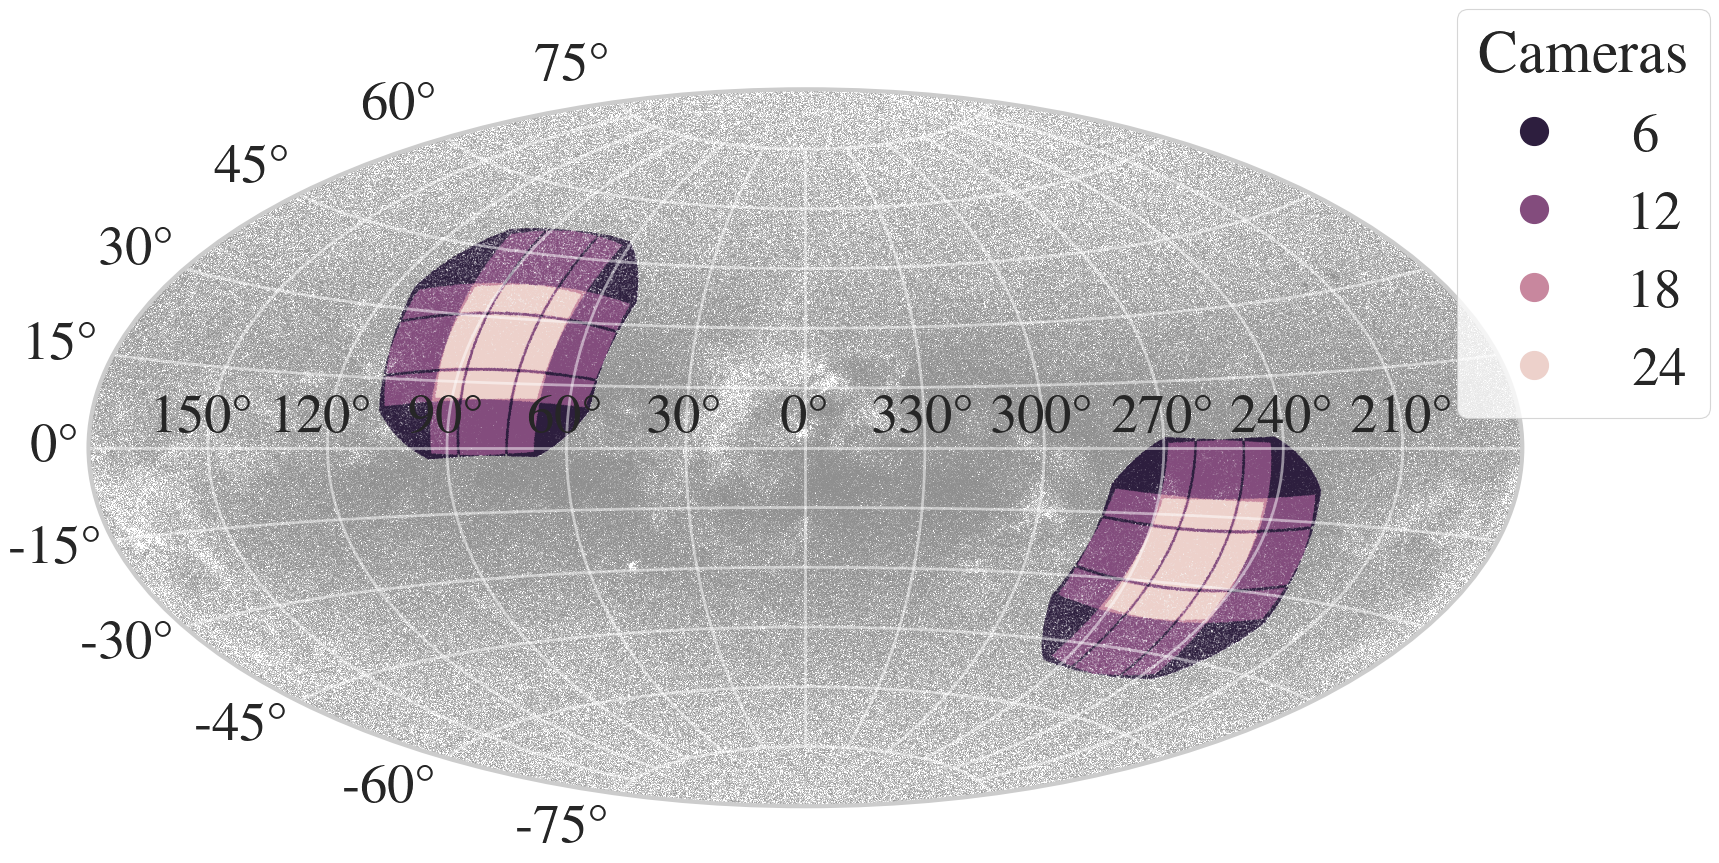

In [7]:
import seaborn as sns
import matplotlib.lines as mlines

with sns.plotting_context(font_scale=1.5):
    fig = plt.figure()
    field_plot = fig.add_subplot(111, projection="aitoff")

    sns.scatterplot(
        data=targets[targets["n_cameras"] == 0],
        x="GLON",
        y="GLAT",
        c="black",
        linewidth=0,
        alpha=0.5,
        s=0.3,
        ax=field_plot,
        rasterized=True,
        zorder=-1,
    )

    # increase thickness of grid lines
    field_plot.grid(True)
    for line in field_plot.get_xgridlines() + field_plot.get_ygridlines():
        line.set_linewidth(2)
        line.set_zorder(-1)
        line.set_color("white")
        line.set_alpha(0.5)

    sns.scatterplot(
        data=targets[targets["n_cameras"] > 0],
        x="GLON",
        y="GLAT",
        c=targets[targets["n_cameras"] > 0]["n_cameras"],
        cmap=get_palette(n_colors=4, as_cmap=True, reverse=True),
        linewidth=0,
        s=0.8,
        ax=field_plot,
        rasterized=True,
        alpha=0.6,
        zorder=-1,
    )

    field_plot.set_xticklabels(
        [
            "150°",
            "120°",
            "90°",
            "60°",
            "30°",
            "0°",
            "330°",
            "300°",
            "270°",
            "240°",
            "210°",
        ]
    )

    field_plot.set_xlabel("")
    field_plot.set_ylabel("")

    handles = []
    for i, n_cam in enumerate((6, 12, 18, 24)):
        handles.append(
            mlines.Line2D(
                [],
                [],
                color=get_palette(n_colors=4, reverse=True)[i],  # type: ignore
                marker="o",
                markersize=20,
                linestyle="None",
                label=f"{n_cam}",
            )
        )

    # Add a custom legend
    field_plot.legend(
        handles=handles,
        loc="upper right",
        bbox_to_anchor=(1.15, 1.15),
        title="Cameras",
    )

    FigureProcessor(field_plot).save(
        "field_plot.pdf",
        figure_directory=figure_directory,
        save=save,
    )

# TARGET TABLE

In [19]:
target_counts = [df["Population"].value_counts() for df in [all_sky, LOPS2, LOPN1]]
# combine into one dataframe with field as index
target_counts = pd.concat(target_counts, axis=1, keys=["All-Sky", "LOPS2", "LOPN1"])
target_counts

,All-Sky,LOPS2,LOPN1
Population,,,
Thin Disk,1218532,134870,147265
Thick Disk Candidate,635392,28884,27057
Thick Disk,72641,4984,5256
Halo,3994,386,392
Halo Candidate,3153,341,391
